In [2]:
###FOR TTBAR BACKGROUND

import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\backgrounds\\tt2l2nu"

samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events

    events["SelElectron"] = events.Electron
    events["SelMuon"] = events.Muon 
    events["SelTau"] = events.Tau

    print("no selection : ")
    no_sel = len(events)
    print(no_sel)
    

    print("Require at least 3 leptons")
    events_temp = events[ak.num(events.SelTau) + ak.num(events.SelMuon) + ak.num(events.SelElectron) >= 3]
    print(len(events_temp))

####
####
#### selection of electron

    events["SelElectron"] = events.Electron[(events.Electron.pt > 24.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]    
    events = events[ak.num(events.SelElectron) <= 3]
    print("after selection of electron (nb.e <=3): ")
    e_sel = len(events)
    print(str(e_sel) + "(-"+str(int(100 -100*(e_sel/no_sel)))+"%)")

####
####
#### selection of muon


    events["SelMuon"] = events.SelMuon[(events.SelMuon.pt > 24.) & (events.SelMuon.mediumPromptId) & (events.SelMuon.pfRelIso03_all < 0.2) & (np.abs(events.SelMuon.dxy) < 0.005)]       
    events = events[ak.num(events.SelMuon) <= 3]
    print("after selection of Muon(nb.mu <=3): ")
    mu_sel = len(events)
    print(str(mu_sel) + "(-"+str(int(100 -100*(mu_sel/e_sel)))+"%)")



####
####
#### basic selection of Tau
    id_tauvsjet = 0.5
    pt_tau = 20
    events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3)]

    events = events[ak.num(events.SelTau) <= 3]
    print("after basic selection of tau (pt, eta) (nb.tau <=3): ")
    tau_sel1 = len(events)
    print(str(tau_sel1) + "(-"+str(int(100 -100*(tau_sel1/mu_sel)))+"%)")

####
####
#### selection of Tau ID vs jet
    id_tauvsjet = 0.5
    pt_tau = 20 
    events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
    events = events[ak.num(events.SelTau) <= 3]
    print("after ID selection of tau (vs jet) (nb.tau <=3): ")
    tau_sel2 = len(events)
    print(str(tau_sel2) + "(-"+str(int(100 -100*(tau_sel2/tau_sel1)))+"%)")


####
####
#### selection of Tau
    id_tauvsjet = 0.5
    pt_tau = 20
    events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3) & (events.SelTau.idDeepTau2017v2p1VSe > 0.5) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
    events = events[ak.num(events.SelTau) <= 3]
    print("after ID selection of tau (vs e) (nb.tau <=3): ")
    tau_sel3 = len(events)
    print(str(tau_sel3) + "(-"+str(int(100 -100*(tau_sel3/tau_sel2)))+"%)")



####
####
#### selection of Tau
    id_tauvsjet = 0.5
    pt_tau = 20
    events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3)& (events.SelTau.idDeepTau2017v2p1VSe > 0.5) & (events.SelTau.idDeepTau2017v2p1VSe > 0.5) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
    events = events[ak.num(events.SelTau) <= 3]
    print("after ID selection of tau (vs mu) (nb.tau <=3): ")
    tau_sel4 = len(events)
    print(str(tau_sel4) + "(-"+str(int(100 -100*(tau_sel4/tau_sel3)))+"%)")



    events = events[ak.num(events.SelTau) + ak.num(events.SelMuon) + ak.num(events.SelElectron)== 3]
    end_of_sel = len(events)
    print("requiring exactly 3 leptons")
    print(str(end_of_sel) + "(-"+str(int(100 -100*(end_of_sel/tau_sel4)))+"%)")

    ####BJET veto
    events["SelLeptons"] = ak.concatenate([events.SelElectron, events.SelMuon, events.SelTau], axis = -1)
    jets = events.Jet[events.Jet.pt > 25.]
    bjets = jets[jets.btagDeepFlavB > 0.2770]
    events["bjet"] = events.Jet[events.Jet.pt > 25.]
    events["bjet"] = events.bjet[events.bjet.btagDeepFlavB > 0.2770]
    bjets_temp, l = ak.unzip(ak.cartesian([events.bjet, events.SelLeptons], nested=True))
    overlap = ak.any(bjets_temp.delta_r(l) < 0.5, axis=-1, mask_identity=False)
    events["bjet"] = events.bjet[~overlap]
    events = events[ak.num(events.bjet) == 0]
    
    jet_sel = len(events)
    print(str(jet_sel) + "(-"+str(int(100 -100*(jet_sel/end_of_sel)))+"%)")


    print("to recall, all events: ")
    print(no_sel)

    print("percentage of remaining bkg events after all selection over total events: "  + "("+str(int(100*(jet_sel/no_sel)))+"%)")

    

C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,


1/1
no selection : 
2025984
Require at least 3 leptons
2025984
after selection of electron (nb.e <=3): 
2025984(-0%)
after selection of Muon(nb.mu <=3): 
2025961(-0%)
after basic selection of tau (pt, eta) (nb.tau <=3): 
1797502(-11%)
after ID selection of tau (vs jet) (nb.tau <=3): 
1797502(-0%)
after ID selection of tau (vs e) (nb.tau <=3): 
1797502(-0%)
after ID selection of tau (vs mu) (nb.tau <=3): 
1797502(-0%)
requiring exactly 3 leptons
228866(-87%)
44566(-80%)
to recall, all events: 
2025984
percentage of remaining bkg events after all selection over total events: (2%)


In [6]:
events_sel = events
print(len(events_sel))
print(events_sel.SelLeptons)
events_sel["Leptons"] = events_sel.SelLeptons
events_sel["Tau"] = events_sel.SelTau
events_sel["Electron"] = events_sel.SelElectron
events_sel["Muon"] = events_sel.SelMuon
print("Muon/electron/tau genPartFlav:")
print(events_sel.Muon.genPartFlav)
print(events_sel.Electron.genPartFlav)
print(events_sel.Tau.genPartFlav)
print("------")
print("nb of electrons: " + str(len(ak.flatten(events_sel.Electron.genPartFlav))))
print("nb of non prompt electron according to genPartFlav: " + str(len(ak.flatten(events_sel.Electron.genPartFlav[events_sel.Electron.genPartFlav != 1]))))

print("------")
print("Muons/electrons/taus genpartIdx:")
print(events_sel.Muon.genPartIdx)
print(events_sel.Electron.genPartIdx)
print(events_sel.Tau.genPartIdx)
print("------")
print("Electron corresponding GenPart pdgId")
print(events_sel.GenPart[events_sel.Electron.genPartIdx].pdgId)
print(np.unique(ak.to_numpy(ak.flatten(events_sel.GenPart[events_sel.Electron.genPartIdx].pdgId))))

print("------")
events_sel["Electron"] = events_sel.Electron[events_sel.Electron.genPartFlav == 1]
events_sel["Muon"] = events_sel.Muon[events_sel.Muon.genPartFlav == 1]
events_sel["Tau"] = events_sel.Tau[events_sel.Tau.genPartFlav >=3]
events_sel["Leptons"] = ak.concatenate([events_sel.Electron,events_sel.Muon,events_sel.Tau], axis = -1)
print(events_sel.Leptons)
print(ak.num(events_sel.Leptons))

44566
[[Electron, Muon, Tau], [Electron, Muon, Tau, ... Tau, Tau], [Electron, Tau, Tau]]
Muon/electron/tau genPartFlav:
[[1], [1], [1], [1], [1], [1], [1], [1], ... [1], [1], [1], [1], [1], [1], [], []]
[[1], [1], [], [1], [], [1], [], [1], [1, ... [], [1], [], [1], [], [1], [1], [1]]
[[2], [0], [2, 0], [0], [2, 0], [0], [2, ... 0, 2], [0], [0, 2], [0], [4, 0], [4, 0]]
------
nb of electrons: 17983
nb of non prompt electron according to genPartFlav: 2240
------
Muons/electrons/taus genpartIdx:
[[13], [19], [20], [17], [17], [16], [12, ... [17], [15], [23], [15], [15], [], []]
[[16], [13], [], [13], [], [21], [], [17, ... [20], [], [18], [], [13], [19], [13]]
[[11], [-1], [18, -1], [-1], [17, -1], ... -1], [-1, 15], [-1], [37, -1], [27, -1]]
------
Electron corresponding GenPart pdgId
[[11], [-11], [], [-11], [], [11], [], ... 11], [], [-11], [], [-11], [11], [-11]]
[-4122  -421  -411   -14   -12   -11    11    12    14    22   211   421
  4332]
------
[[Electron, Muon], [Electron, Muon

C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,


events are charged!


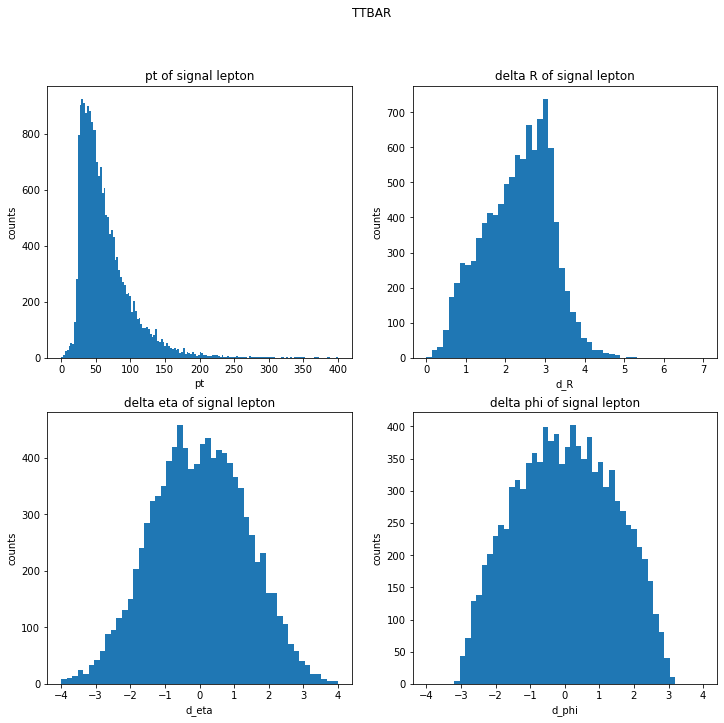

In [21]:
###FOR TTBAR BACKGROUND

import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\backgrounds\\tt2l2nu"

samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
file = samples[0][0]
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema, entry_stop= 10000).events()
print("events are charged!")
gp = events.GenPart[events.GenPart.hasFlags(['isLastCopy'])]

W = gp[abs(gp.pdgId) == 24]
tau_from_W = ak.flatten(W.distinctChildren[abs(W.distinctChildren.pdgId) == 15], axis = 2)
electron_from_W = ak.flatten(W.distinctChildren[abs(W.distinctChildren.pdgId) == 11], axis = 2)
muon_from_W = ak.flatten(W.distinctChildren[abs(W.distinctChildren.pdgId) == 13], axis = 2)
all_from_W = ak.concatenate([electron_from_W, muon_from_W, tau_from_W], axis = 1)
all_from_W = all_from_W[all_from_W.hasFlags(['isLastCopy'])]
all_from_W = all_from_W[ak.num(all_from_W) == 2]

pt_signal = ak.to_numpy(ak.flatten(all_from_W.pt))
dr_signal = ak.to_numpy(delta_r(all_from_W[:,0], all_from_W[:,1]))
d_eta_signal = ak.to_numpy(delta_eta(all_from_W[:,0], all_from_W[:,1]))
d_phi_signal = ak.to_numpy(delta_phi(all_from_W[:,0], all_from_W[:,1]))


plt.figure(figsize=(12,11))
plt.suptitle("TTBAR")
plt.subplot(2, 2, 1)
plt.hist(pt_signal, bins = 150, range = (0,400))
plt.title("pt of signal lepton")
plt.xlabel('pt')
plt.ylabel('counts')

plt.subplot(2, 2, 2)
plt.hist(dr_signal, bins = 50, range = (0,7))
plt.title("delta R of signal lepton")
plt.xlabel('d_R')
plt.ylabel('counts')

plt.subplot(2, 2, 3)
plt.hist(d_eta_signal, bins = 50, range = (-4,4))
plt.title("delta eta of signal lepton")
plt.xlabel('d_eta')
plt.ylabel('counts')

plt.subplot(2, 2, 4)
plt.hist(d_phi_signal, bins = 50, range = (-4,4))
plt.title("delta phi of signal lepton")
plt.xlabel('d_phi')
plt.ylabel('counts')
plt.savefig('ttbar_true_signal_observables.pdf')
plt.show()




C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,


1/1


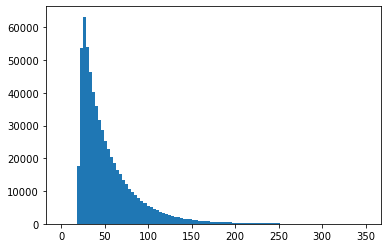

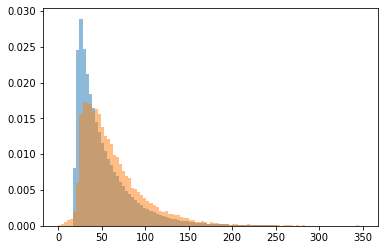

In [89]:
###FOR TTBAR BACKGROUND

import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\backgrounds\\tt2l2nu"

samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
file = samples[0][0]
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema, entry_stop = 1000000).events()
print(str(i_file)+"/"+str(len(samples[0])))
i_file = i_file+1
nb_events = len(events)
tot_events = tot_events+nb_events
events["SelElectron"] = events.Electron
events["SelMuon"] = events.Muon 
events["SelTau"] = events.Tau
events_temp = events[ak.num(events.SelTau) + ak.num(events.SelMuon) + ak.num(events.SelElectron) >= 3]


events["SelElectron"] = events.Electron[(events.Electron.pt > 24.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]    
events = events[ak.num(events.SelElectron) <= 3]


events["SelMuon"] = events.SelMuon[(events.SelMuon.pt > 24.) & (events.SelMuon.mediumPromptId) & (events.SelMuon.pfRelIso03_all < 0.2) & (np.abs(events.SelMuon.dxy) < 0.005)]       

muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
events['SelMuon'] = events.SelMuon[(~(match1))] 


events = events[ak.num(events.SelMuon) <= 3]

id_tauvsjet = 0.5
id_tauvse = 0.5
id_tauvsmu = 0.5

pt_tau = 20
events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3)]
events = events[ak.num(events.SelTau) <= 3]


pt_tau = 20 
events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
events = events[ak.num(events.SelTau) <= 3]


pt_tau = 20
events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3) & (events.SelTau.idDeepTau2017v2p1VSe > id_tauvse) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
events = events[ak.num(events.SelTau) <= 3]


id_tauvsjet = 0.5
pt_tau = 20
events["SelTau"] = events.SelTau[(events.SelTau.pt > pt_tau) & (abs(events.SelTau.eta) < 2.3)& (events.SelTau.idDeepTau2017v2p1VSmu > id_tauvsmu) & (events.SelTau.idDeepTau2017v2p1VSe > id_tauvse) & (events.SelTau.idDeepTau2017v2p1VSjet >=id_tauvsjet)]
tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False) 
events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]  



events = events[ak.num(events.SelTau) <= 3]
events = events[ak.num(events.SelTau) + ak.num(events.SelMuon) + ak.num(events.SelElectron)== 3]
####BJET veto
events["SelLeptons"] = ak.concatenate([events.SelElectron, events.SelMuon, events.SelTau], axis = -1)
jets = events.Jet[events.Jet.pt > 25.]
bjets = jets[jets.btagDeepFlavB > 0.2770]
events["bjet"] = events.Jet[events.Jet.pt > 25.]
events["bjet"] = events.bjet[events.bjet.btagDeepFlavB > 0.2770]
bjets_temp, l = ak.unzip(ak.cartesian([events.bjet, events.SelLeptons], nested=True))
overlap = ak.any(bjets_temp.delta_r(l) < 0.5, axis=-1, mask_identity=False)
events["bjet"] = events.bjet[~overlap]
events = events[ak.num(events.bjet) == 0]

leptons = events.SelLeptons








pt_data = ak.flatten(leptons.pt)
plt.hist(pt_data, bins = 100, range = (0,350))
plt.show()

plt.hist(pt_data, bins = 100, range = (0,350), alpha = 0.5, density = True)
plt.hist(pt_signal, bins = 100, range = (0,350), alpha = 0.5, density = True)
plt.show()


In [110]:
events["prompt_e"] = events.SelElectron[events.SelElectron.genPartFlav == 1]
events["prompt_m"] = events.SelMuon[events.SelMuon.genPartFlav == 1]
promp_t_match_mu = events.SelTau.genPartFlav == 2
promp_t_match_e = events.SelTau.genPartFlav == 1
promp_t_match_to_mu = events.SelTau.genPartFlav == 4
promp_t_match_to_e = events.SelTau.genPartFlav == 3
promp_t_match_to_h = events.SelTau.genPartFlav == 5
events["prompt_t"] = events.SelTau[promp_t_match_e | promp_t_match_mu | promp_t_match_to_e | promp_t_match_to_mu | promp_t_match_to_h]
events = events[ak.num(events.prompt_e) +ak.num(events.prompt_m) + ak.num(events.prompt_t) == 2]

non_prompt_e = events.SelElectron[events.SelElectron.genPartFlav != 1]
non_prompt_m = events.SelMuon[events.SelMuon.genPartFlav != 1]
promp_t_match_mu = events.SelTau.genPartFlav == 2
promp_t_match_e = events.SelTau.genPartFlav == 1
promp_t_match_to_mu = events.SelTau.genPartFlav == 4
promp_t_match_to_e = events.SelTau.genPartFlav == 3
promp_t_match_to_h = events.SelTau.genPartFlav == 5
non_prompt_t = events.SelTau[~(promp_t_match_e | promp_t_match_mu | promp_t_match_to_e | promp_t_match_to_mu | promp_t_match_to_h)]


print("number of events with exactly 2 prompt leptons: "  + str(len(events)))
print("number of non-prompt electrons : " + str(len(ak.flatten(non_prompt_e))))
print("number of non-prompt muons : " + str(len(ak.flatten(non_prompt_m))))
print("number of non-prompt taus : " + str(len(ak.flatten(non_prompt_t))))

number of events with exactly 2 prompt leptons: 174106
number of non-prompt electrons : 5095
number of non-prompt muons : 3551
number of non-prompt taus : 165460


In [49]:
print(leptons.genPartFlav)
print(leptons)
print(leptons.genPartIdx)
print(leptons.pt)
leptons_pos = leptons[leptons.charge == 1]
leptons_neg = leptons[leptons.charge == -1]
pos2_neg1_temp1 = leptons_pos[ak.num(leptons_pos) == 2]
pos2_neg1_temp2 = leptons_neg[ak.num(leptons_pos) == 2]
pos2_neg1 = ak.concatenate([pos2_neg1_temp1, pos2_neg1_temp2], axis = -1)
print("sorted (two first are pos and third one are neg")
print(pos2_neg1.charge)
print("-----")
print("delta r of (l0,l1) and (l0,l2)")
dr1 = delta_r(pos2_neg1[:,0], pos2_neg1[:,2])
dr2 = delta_r(pos2_neg1[:,1], pos2_neg1[:,2])
print(dr1)
print(dr2)
print("-----")
print("delta phi of (l0,l1) and (l0,l2)")

dphi1 = delta_phi(pos2_neg1[:,0], pos2_neg1[:,2])
dphi2 = delta_phi(pos2_neg1[:,1], pos2_neg1[:,2])
print(dphi1)
print(dphi2)
print("-----")
print("delta eta of (l0,l1) and (l0,l2)")

deta1 = delta_eta(pos2_neg1[:,0], pos2_neg1[:,2])
deta2 = delta_eta(pos2_neg1[:,1], pos2_neg1[:,2])
print(deta1)
print(deta2)
print("-----")

dphi1 = ak.unflatten(dphi1, np.ones(len(dphi1), dtype=int))
dphi2 = ak.unflatten(dphi2, np.ones(len(dphi2), dtype=int))
dphi = ak.concatenate([dphi1, dphi2], axis = -1)
print("removing same value (probably misidentified leptons)")
print("from " + str(len(dphi)))
dphi = dphi[dphi[:,0] != dphi[:,1]]
print("to "+ str(len(dphi)))
first_small = dphi[abs(dphi[:,0]) <= abs(dphi[:,1])]
small1 = first_small[:,0]
second_small = dphi[abs(dphi[:,0]) >= abs(dphi[:,1])]
small2 = second_small[:,1]
pair_small2 = ak.concatenate([pos2_neg1[:,1],pos2_neg1[:,2]], axis = -1)
small = ak.concatenate([small1, small2])
big2 = first_small[:,1]
big1 = second_small[:,0]
big = ak.concatenate([big1, big2])





plt.figure(figsize=(21,16))
plt.suptitle("TTBAR data 3 leptons")
plt.subplot(3, 3, 1)

plt.title("smallest absolute dphi of the pair")
plt.hist(small, bins = 50, range=(-4,4))
plt.xlabel('d_phi')
plt.ylabel('counts')

plt.subplot(3, 3, 2)

plt.title("biggest absolute dphi of the pair")
plt.hist(big, bins = 50, range=(-4,4))
plt.xlabel('d_phi')
plt.ylabel('counts')

plt.subplot(3, 3, 3)
plt.hist(d_phi_signal, bins = 50, range = (-4,4))
plt.title("dphi of true pairs")
plt.xlabel('d_phi')
plt.ylabel('counts')


print("-----")

dr1 = ak.unflatten(dr1, np.ones(len(dr1), dtype=int))
dr2 = ak.unflatten(dr2, np.ones(len(dr2), dtype=int))
dri = ak.concatenate([dr1, dr2], axis = -1)
dri = dri[dri[:,0] != dri[:,1]]
first_small = dri[abs(dri[:,0]) <= abs(dri[:,1])]
small1 = first_small[:,0]
second_small = dri[abs(dri[:,0]) >= abs(dri[:,1])]
small2 = second_small[:,1]
pair_small2 = ak.concatenate([pos2_neg1[:,1],pos2_neg1[:,2]], axis = -1)
small = ak.concatenate([small1, small2])
big2 = first_small[:,1]
big1 = second_small[:,0]
big = ak.concatenate([big1, big2])

plt.subplot(3, 3, 4)

plt.title("smallest absolute dri of the pair")
plt.hist(small, bins = 50, range=(0,6.5))
plt.xlabel('d_r')
plt.ylabel('counts')

plt.subplot(3, 3, 5)
plt.title("biggest absolute dri of the pair")
plt.hist(big, bins = 50, range=(0,6.5))
plt.xlabel('d_r')
plt.ylabel('counts')

plt.subplot(3, 3, 6)
plt.hist(dr_signal, bins = 50, range = (0,6.5))
plt.title("dr of true pairs")
plt.xlabel('d_r')
plt.ylabel('counts')



print("-----")

deta1 = ak.unflatten(deta1, np.ones(len(deta1), dtype=int))
deta2 = ak.unflatten(deta2, np.ones(len(deta2), dtype=int))
deta = ak.concatenate([deta1, deta2], axis = -1)
deta = deta[deta[:,0] != deta[:,1]]
first_small = deta[abs(deta[:,0]) <= abs(deta[:,1])]
small1 = first_small[:,0]
second_small = deta[abs(deta[:,0]) >= abs(deta[:,1])]
small2 = second_small[:,1]
pair_small2 = ak.concatenate([pos2_neg1[:,1],pos2_neg1[:,2]], axis = -1)
small = ak.concatenate([small1, small2])
big2 = first_small[:,1]
big1 = second_small[:,0]
big = ak.concatenate([big1, big2])

plt.subplot(3, 3, 7)
plt.title("smallest absolute deta of the pair")
plt.hist(small, bins = 50, range=(-4,4))
plt.xlabel('d_eta')
plt.ylabel('counts')


plt.subplot(3, 3, 8)
plt.title("biggest absolute deta of the pair")
plt.hist(big, bins = 50, range=(-4,4))
plt.xlabel('d_eta')
plt.ylabel('counts')

plt.subplot(3, 3, 9)
plt.hist(d_eta_signal, bins = 50, range = (-4,4))
plt.title("deta of true pairs")
plt.xlabel('d_eta')
plt.ylabel('counts')
plt.savefig('ttbar_find_fake_leptons.pdf')
plt.show()




[[1, 1, 0], [1, 0, 0], [1, 1, 0], [1, 1, ... 1, 0], [1, 0, 0], [1, 1, 0], [1, 1, 0]]
[[Electron, Muon, Tau], [Muon, Tau, Tau], ... [Muon, Muon, Tau], [Muon, Muon, Tau]]
[[13, 15, -1], [12, -1, -1], [17, 14, -1, ... -1, -1], [18, 15, -1], [19, 16, -1]]
[[86, 56.5, 21.1], [50.5, 37.3, 30.3], ... [29.5, 27.2, 34.3], [44.8, 35.4, 33.4]]


KeyboardInterrupt: 

In [87]:
###FOR TTBAR BACKGROUND

import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\backgrounds\\tt2l2nu"

samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
file = samples[0][0]
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema, entry_stop = 1000000).events()


W = events.GenPart[abs(events.GenPart.pdgId) == 24]
print(W)
print(ak.num(W))
print(W[W.hasFlags(['isLastCopy'])])
print(ak.num(W[W.hasFlags(['isLastCopy'])]))
print(np.unique(ak.num(W[W.hasFlags(['isLastCopy'])])))

C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
C:\Users\lucas\miniconda3\envs\env_conda\envs\PDM\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,


[[GenParticle, GenParticle, GenParticle], ... GenParticle, GenParticle, GenParticle]]
[3, 3, 4, 4, 3, 4, 3, 2, 3, 3, 2, 4, 2, 3, ... 5, 4, 4, 4, 4, 3, 3, 3, 3, 4, 5, 4, 4]
[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2]
